In [22]:
import os, random
import matplotlib.pyplot as plt
from math import log
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [23]:
dir = '/Users/k/Docs/School/Tuebingen/Thesis/iscl-thesis/current_corpora/'
files = [os.path.join(dir, file) for file in os.listdir(dir) if file.endswith('.txt')]

Type-Token Ratio

In [24]:
def calculate_ttr(file):
    
    with open(file, 'r', encoding='utf-8') as f:
        text = f.read()
    f.close()
    
    tokens = text.split()
    total_tokens = len(tokens)
    types = set(tokens)
    total_types = len(types)
    ttr = (total_types / total_tokens) * 100
    return ttr

ttr_values = {}
for file in files:
    lang = os.path.splitext(os.path.basename(file))[0].split('_')[0]
    ttr_values[lang] = calculate_ttr(file)

Moving Average Type-Token Ratio

In [25]:
def calculate_mattr(file, window_size):
    
    with open(file, 'r', encoding='utf-8') as f:
        text = f.read()
    f.close()
    
    tokens = text.split()
    total_tokens = len(tokens)
    
    ttr_values = []
    for i in range(total_tokens - window_size + 1):
        window = tokens[i:i + window_size]
        types = set(window)
        total_types = len(types)
        ttr = total_types / window_size
        ttr_values.append(ttr)

    mattr = sum(ttr_values) / len(ttr_values)
    return mattr

mattr_values = {}
window_size = 100  
for file in files:
    lang = os.path.splitext(os.path.basename(file))[0].split('_')[0]
    mattr_values[lang] = calculate_mattr(file, window_size)

Character Entropy

In [26]:
def log2(number):
    return log(number) / log(2)

def calculate_char_entropy(file):
    with open(file, 'r', encoding='utf-8') as f:
        text = f.read()
    f.close()
    
    char_freq = {}
    for char in text:
        if char in char_freq:
            char_freq[char] += 1
        else:
            char_freq[char] = 1
            
    length_sum = 0.0
    for char in char_freq:
        p = float(char_freq[char]) / len(text)
        length_sum += p * log2(p)
        
    return -length_sum

char_entropies = {}
for file in files:
    lang = os.path.splitext(os.path.basename(file))[0].split('_')[0]
    char_entropies[lang] = calculate_char_entropy(file)

Word Entropy

In [27]:
def log2(number):
    return log(number) / log(2)

def calculate_word_entropy(file):
    with open(file, 'r', encoding='utf-8') as f:
        text = f.read()
    f.close()
    
    word_freq = {}
    total_words = 0
    for word in text.split():
        if word in word_freq:
            word_freq[word] += 1
        else:
            word_freq[word] = 1
        total_words += 1
            
    length_sum = 0.0
    for word in word_freq:
        p = float(word_freq[word]) / total_words
        length_sum += p * log2(p)
        
    return -length_sum

word_entropies = {}
for file in files:
    lang = os.path.splitext(os.path.basename(file))[0].split('_')[0]
    word_entropies[lang] = calculate_word_entropy(file)

Dataframe

In [28]:
calculations = {
   'TTR': ttr_values,
   'MATTR': mattr_values,
   'Char Entr': char_entropies,
   'Word Entr': word_entropies
}

for label, dic in calculations.items():
    calculations[label] = pd.Series(dic)

df = pd.DataFrame(calculations)
print(df)

           TTR     MATTR  Char Entr  Word Entr
sv   14.061651  0.775335   4.464237  11.853898
id    9.055650  0.736550   4.247598  11.645854
eo   14.094830  0.713749   4.364869  11.341934
is   14.228417  0.763329   4.640164  11.822959
pl   18.436960  0.841216   4.709730  13.239587
da   13.841666  0.760867   4.379437  11.671829
tl   10.563946  0.629534   4.080281  10.366187
ia    9.655543  0.623515   4.193442  10.360155
fi   24.195725  0.858694   4.320068  14.068596
vi    3.461837  0.757848   5.011508  10.167612
hu   20.986695  0.795651   4.726970  12.953072
nl   11.322807  0.710276   4.282414  10.937256
lfn   7.738075  0.626380   4.097299   9.779663
es   10.376208  0.697050   4.295935  10.788501
io    7.435898  0.649247   4.562268   9.536977
af    9.499201  0.668535   4.278238  10.382296
fr   10.116588  0.737595   4.366594  11.053416
it   12.072329  0.782554   4.249491  11.691508
tr   18.133747  0.847956   4.601831  13.616526
de   15.480026  0.788966   4.403190  11.956956
oc    9.08760

In [29]:
df['corpus'] = df.index
df = df[['corpus', 'TTR', 'MATTR', 'Char Entr', 'Word Entr']]
df.to_csv('prelim', sep='\t', index=False)

Principle Component Analysis

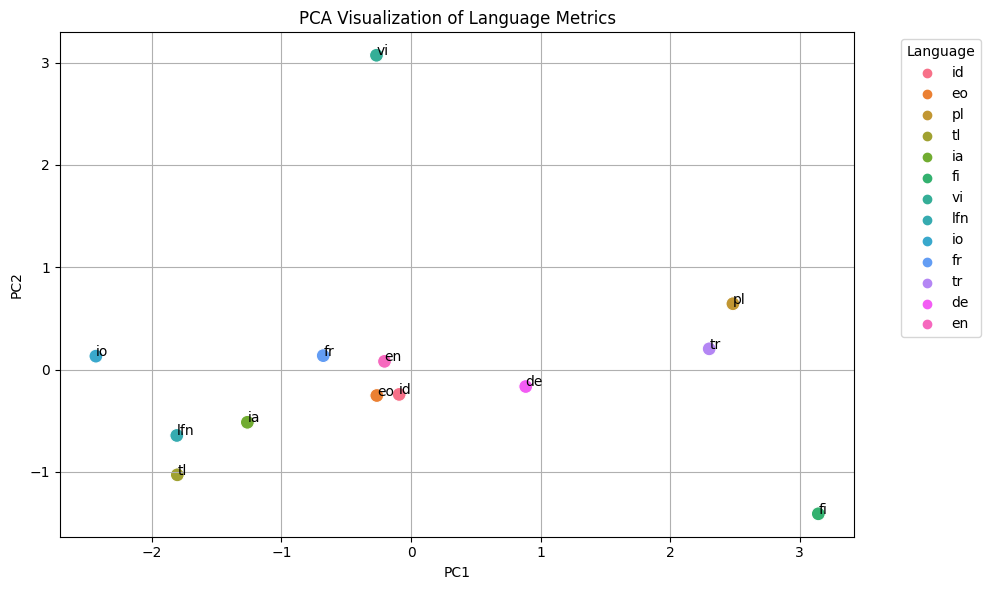

In [118]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

pca = PCA(n_components=0.95)
pca_result = pca.fit_transform(scaled_data)

pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df.index = df.index

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', data=pca_df, hue=pca_df.index, s=100)

for i, language in enumerate(pca_df.index):
    plt.annotate(language, (pca_df['PC1'][i], pca_df['PC2'][i]))
    
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Visualization of Language Metrics')
plt.grid(True)
plt.legend(title='Language', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [119]:
pca.explained_variance_ratio_

array([0.70788794, 0.26553177])

Char Embeddings: Char2Vec (from https://github.com/sonlamho/Char2Vec/tree/master)

In [1]:
from Char2Vec.char2vec.utils import *
from Char2Vec.char2vec.embed import *

2023-08-12 15:53:54.113690: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
corpus_path = '/Users/k/Docs/School/Tuebingen/Thesis/iscl-thesis/current_corpora/en_wiki_extractor.txt'
alpha = 'abcdefghijklmnopqrstuvwxyz '

In [5]:
m = Char2Vec(corpus_path, config=CONFIG, alphabet=alpha, unk='~')
m.train()

Training 30001 steps with batch size 32...
Step       0:  loss=0.6926055550575256
Step    3000:  loss=0.13298708200454712
Step    6000:  loss=0.13253460824489594
Step    9000:  loss=0.1319156438112259
Step   12000:  loss=0.13030849397182465
Step   15000:  loss=0.1307506114244461
Step   18000:  loss=0.12537886202335358
Step   21000:  loss=0.13021348416805267
Step   24000:  loss=0.13516418635845184
Step   27000:  loss=0.1304122656583786
Step   30000:  loss=0.13159047067165375
Training 501 steps with batch size 512...
Step       0:  loss=0.13171814382076263
Step     500:  loss=0.12695202231407166


In [6]:
# Visualize Char Embeddings
def scatter2d_with_annotation(arr, text, xcol=0, ycol=1, fontsize=7, show=False, **kwargs):
    
    assert len(arr)==len(text)
    fig, ax = plt.subplots(**kwargs)
    xarr = arr[:, xcol]
    yarr = arr[:, ycol]
    plt_texts = []
    
    for i in range(len(text)):
        plt.scatter(xarr[i], yarr[i])
        plt_texts.append(plt.text(xarr[i], yarr[i], text[i], fontsize=fontsize))
        
    if show:
        plt.show()
    return fig, ax

# Char embedding matrix U
U = m.U_

p = PCA()

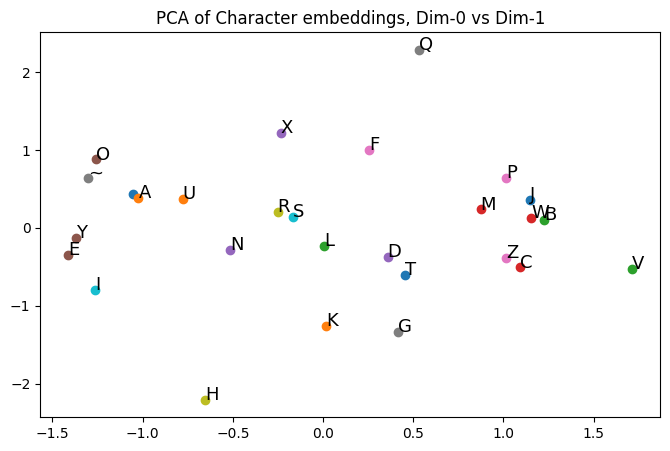

In [10]:
U2 = p.fit_transform(U)
texts = m._tokenizer.alphabet + [m._tokenizer.unk]
fig, ax = scatter2d_with_annotation(
            U2, [s.upper() for s in texts],
            0,1,
            figsize=(8,5), fontsize=13)
plt.title('PCA of Character embeddings, Dim-0 vs Dim-1')
plt.show()

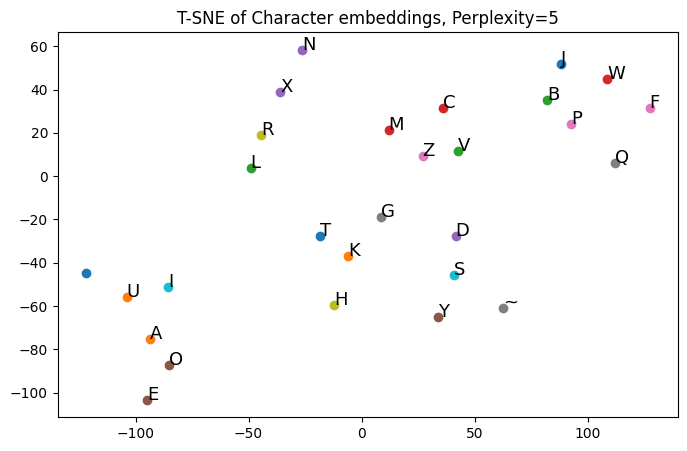

In [11]:
U3 = TSNE(n_components=2, perplexity=5).fit_transform(U)
fig, ax = scatter2d_with_annotation(
            U3, [s.upper() for s in texts],
            0,1,
            figsize=(8,5), fontsize=13)
plt.title('T-SNE of Character embeddings, Perplexity=5')
plt.show()